In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gaming/videoplayback.mp4
/kaggle/input/gaming/CG _ HonorofKingsJurassic World RebirthCollaboration.mp4


In [2]:
import cv2

# 打开视频文件
cap = cv2.VideoCapture('/kaggle/input/gaming/videoplayback.mp4')
# 获取视频参数
fps = cap.get(cv2.CAP_PROP_FPS)  # 帧率
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # 宽
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # 高
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # 总帧数
duration = frame_count / fps / 60  # 持续时间（分钟）

print(f"视频信息: {frame_count}帧, {fps} FPS, {width}x{height}, 大约 {duration:.2f} 分钟")

视频信息: 95956帧, 60.0 FPS, 1920x1080, 大约 26.65 分钟


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32422 (\N{CJK UNIFIED IDEOGRAPH-7EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


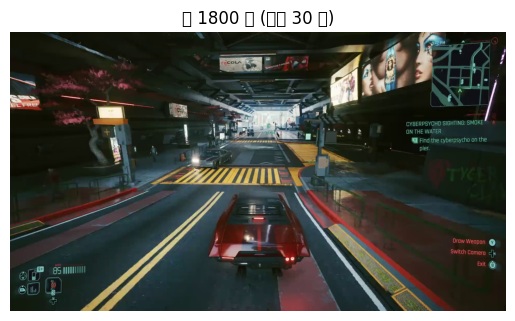

In [3]:
target_time = 30  # 比如 30 秒

    # 计算目标帧号
target_frame = int(fps * target_time)
cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)

# 读取该帧
ret, frame = cap.read()

if ret:
    # 显示图像（在 notebook 环境用 matplotlib）
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"第 {target_frame} 帧 (约第 {target_time} 秒)")
    plt.show()
else:
    print("读取失败，可能超出了视频总长度") 

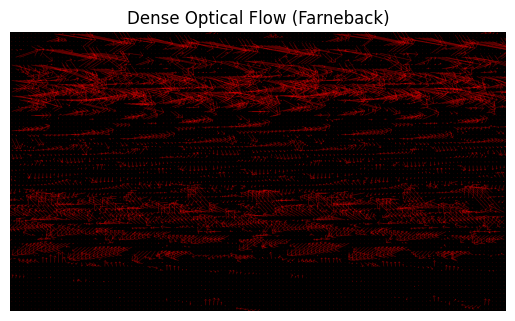

In [4]:
# 将图像转为灰度
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两帧图像
cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
ret1, frame1 = cap.read()

cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame + 5)
ret2, frame2 = cap.read()

# 转灰度
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

def customflow(gray1, gray2, window_size=9):
    # 计算图像梯度
    Ix = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=3)
    It = gray2 - gray1  # 时间梯度

    u = np.zeros_like(gray1)
    v = np.zeros_like(gray1)
    
    half_w = window_size // 2
    h, w = gray1.shape

    # 遍历图像中的像素点（忽略边界）
    for y in range(half_w, h - half_w):
        for x in range(half_w, w - half_w):
            # 提取窗口
            Ix_win = Ix[y - half_w:y + half_w + 1, x - half_w:x + half_w + 1].flatten()
            Iy_win = Iy[y - half_w:y + half_w + 1, x - half_w:x + half_w + 1].flatten()
            It_win = It[y - half_w:y + half_w + 1, x - half_w:x + half_w + 1].flatten()

            # 构造 A 和 b：A · [u, v] = -b
            A = np.vstack((Ix_win, Iy_win)).T
            b = -It_win

            # 检查矩阵是否可逆（防止病态）
            nu = np.linalg.pinv(A.T @ A) @ A.T @ b
            u[y, x] = nu[0]
            v[y, x] = nu[1]

    return np.stack((u, v), axis=-1)*0.1
# 计算稠密光流（Farneback 方法）
flow = -cv2.calcOpticalFlowFarneback(
    gray1, gray2, None,
    pyr_scale=0.5, levels=5, winsize=15,
    iterations=3, poly_n=5, poly_sigma=1.2, flags=0
)  # flow shape: (H, W, 2)
# flow=customflow(gray1, gray2)
# 网格点采样（为了画箭头）
step = 15  # 间隔可调
h, w = gray1.shape
y, x = np.mgrid[step//2:h:step, step//2:w:step].astype(int)
fx, fy = flow[y, x].T  # 对应网格点的光流分量

# 在空白上画箭头
h, w = frame1.shape[:2]
vis = np.zeros((h, w, 3), dtype=np.uint8)  # BGR 彩色空白图

for (x0, y0, dx, dy) in zip(x.ravel(), y.ravel(), fx.ravel(), fy.ravel()):
    x1 = int(x0 + dx)
    y1 = int(y0 + dy)
    cv2.arrowedLine(vis, (x0, y0), (x1, y1), (255, 0, 0), 1, tipLength=0.3)

# 显示结果
plt.imshow(vis)
plt.title("Dense Optical Flow (Farneback)")
plt.axis('off')
plt.show()


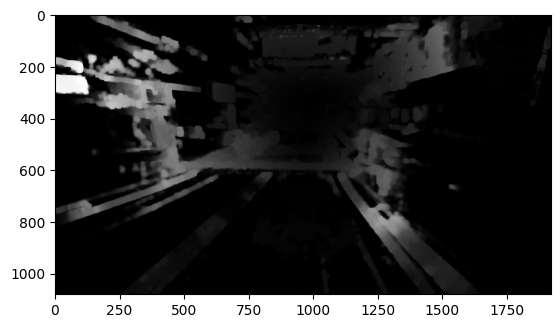

In [5]:
#depth map
# 计算光流长度（每个像素的光流向量模长）
flow_magnitude = np.linalg.norm(flow, axis=2)  # shape: (H, W)

# 将光流长度归一化到 [0, 255]（用于可视化）
depth_map = cv2.normalize(flow_magnitude, None, 0, 255, cv2.NORM_MINMAX)
depth_map = depth_map.astype(np.uint8)
plt.imshow(depth_map, cmap='gray')

In [6]:


# 构造所有像素位置作为“p0”
y, x = np.mgrid[0:h, 0:w]
p0 = np.stack([x, y], axis=-1).reshape(-1, 2)  # (H*W, 2)
flow_vec = flow.reshape(-1, 2)  # (H*W, 2)
p1 = p0 + flow_vec
# 单位方向向量
unit_flow = flow_vec / (np.linalg.norm(flow_vec, axis=1, keepdims=True) + 1e-6)

# 过滤静态区域（如 norm 太小的）
valid = np.linalg.norm(flow_vec, axis=1) > 0.5

# 计算单位方向的平均（只考虑有效区域）
mean_dir = np.mean(unit_flow[valid], axis=0)
vx, vy = mean_dir
if abs(vy) > abs(vx):  # 主要是纵向运动
    if vy > 0.:
        print("Moving forward")
    elif vy < -0.:
        print("Moving backward")
    else:
        print("Small vertical movement")
else:  # 主要是左右偏移
    if vx > 0.:
        print("Turning right")
    elif vx < -0.:
        print("Turning left")
    else:
        print("Small horizontal movement")

print(vx,vy)


Moving forward
0.01919965 0.032344166


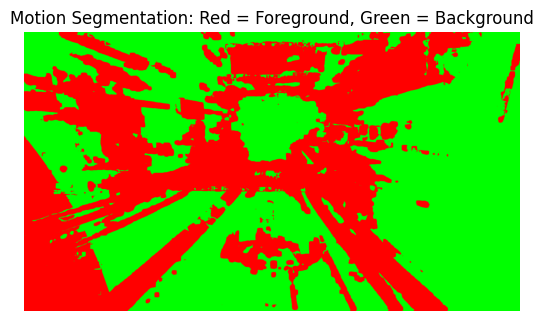

In [7]:
# 用RANSAC拟合背景运动（仿射变换）
M, inliers = cv2.findHomography(p0, p1, method=cv2.RANSAC, ransacReprojThreshold=5.0)

# inliers: shape (N, 1)，为 1 的是背景（拟合得好），0 是前景（拟合失败）
motion_mask = (inliers.ravel() == 0)  # 前景点为 True

# 创建空白画布（黑色背景）
h, w = frame1.shape[:2]
vis = np.zeros((h, w, 3), dtype=np.uint8)  # BGR 彩色空白图

# 绘制前景（红）或背景（绿）点
for (x, y), is_moving in zip(p0, motion_mask):
    x, y = int(round(x)), int(round(y))
    if 0 <= x < w and 0 <= y < h:
        color = (0, 0, 255) if is_moving else (0, 255, 0)
        cv2.circle(vis, (x, y), 3, color, -1)

# 显示分割结果图像
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Motion Segmentation: Red = Foreground, Green = Background")
plt.axis('off')
plt.show()